In [31]:
# Boilerplate at top of file
%load_ext autoreload
%load_ext rmagic
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from ggplot import *

import json


from IPython.display import Image



from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import sklearn.cross_validation as cross_validation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic


In [32]:
print plt.style.available

[u'dark_background', u'bmh', u'grayscale', u'ggplot', u'fivethirtyeight']


In [33]:
df_left = pd.read_csv('data/merged/look_left.csv')
df_right = pd.read_csv('data/merged/look_right.csv')

df_straight = pd.read_csv('data/merged/look_straight.csv')
### hack
# Assume class 0 is always when face is forward for any data set

# look-right events are class 3 and 4
df_right['class'] = df_right['class'].apply(lambda x: x + 2 if x > 0 else 0)
df = pd.concat([df_left, df_right])
n = len(df)



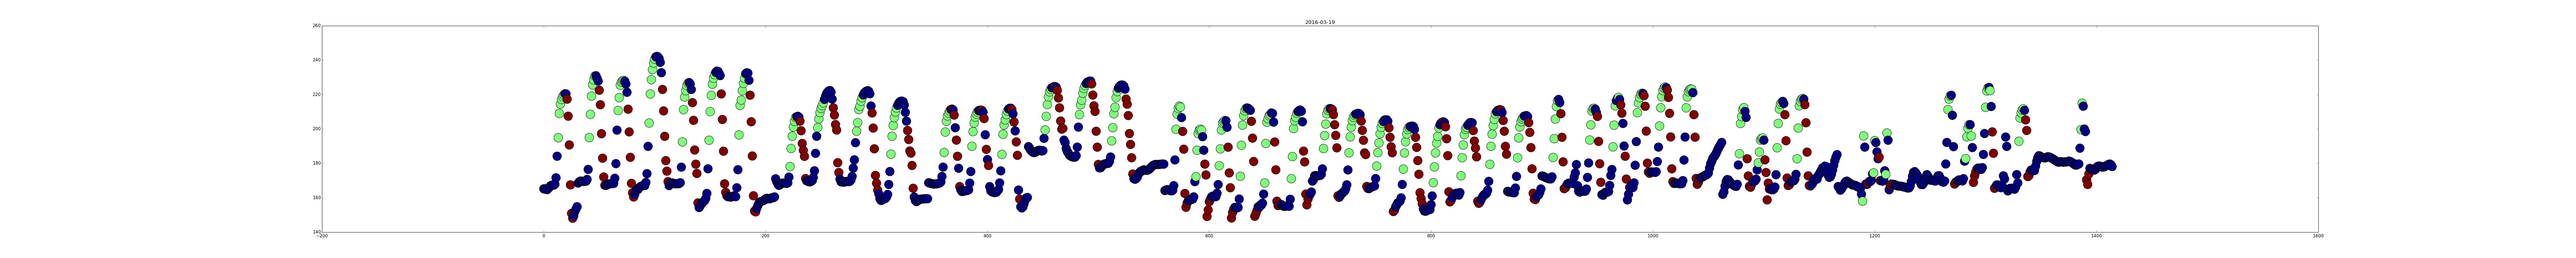

In [34]:
Image(filename='data/merged/look_left-plots.png')


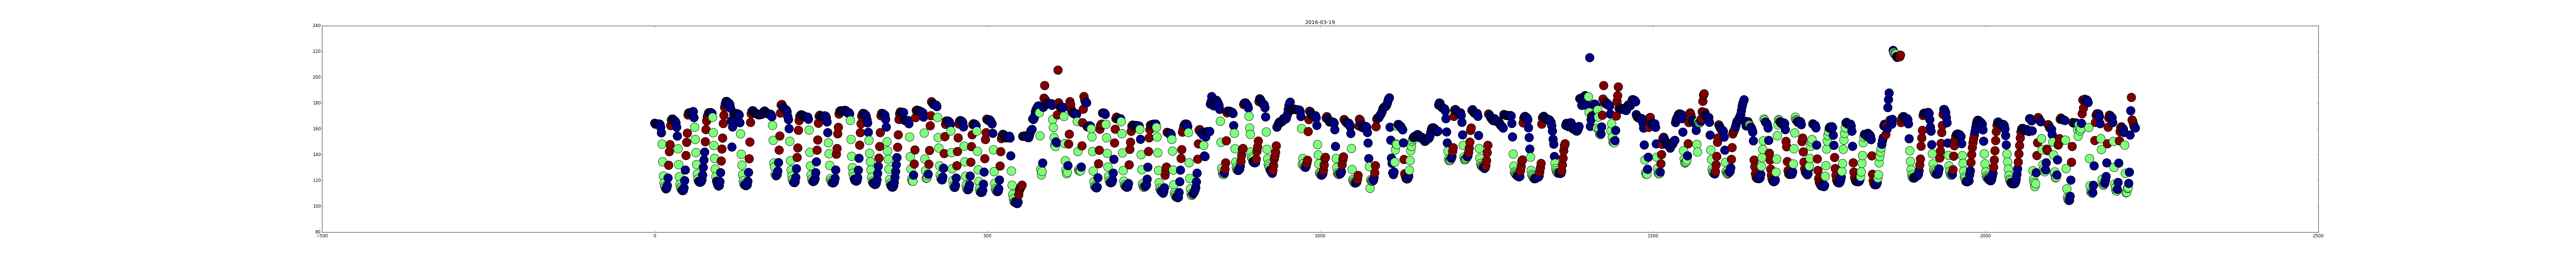

In [35]:
Image(filename='data/merged/look_right-plots.png')

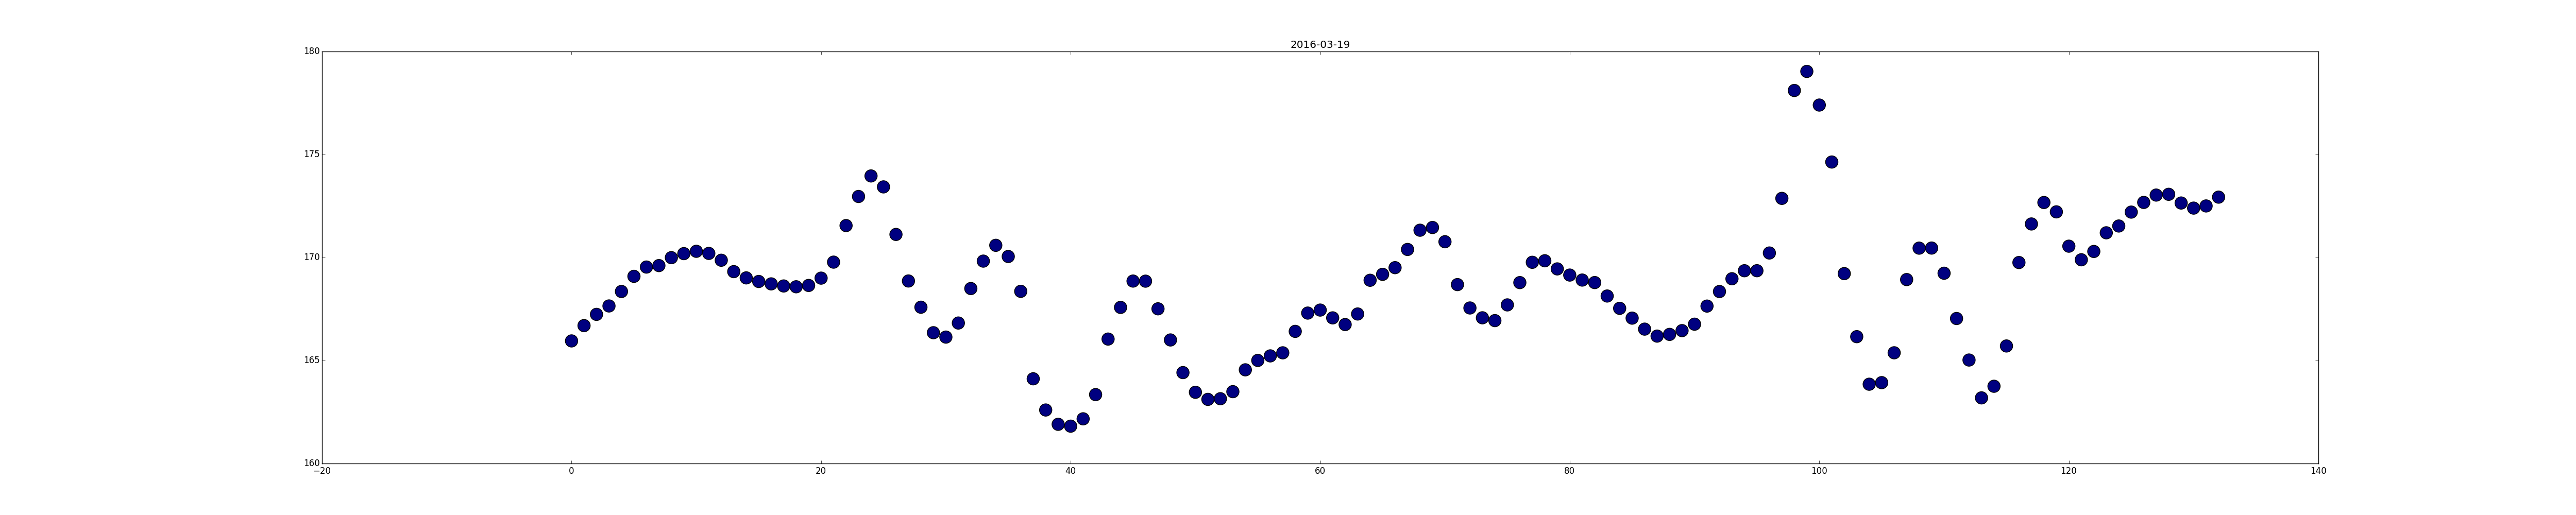

In [36]:
Image(filename='data/merged/look_straight-plots.png')


In [37]:
config = json.loads(open('config.json','r').read())
active_features = config['active_features']

0.929689645702


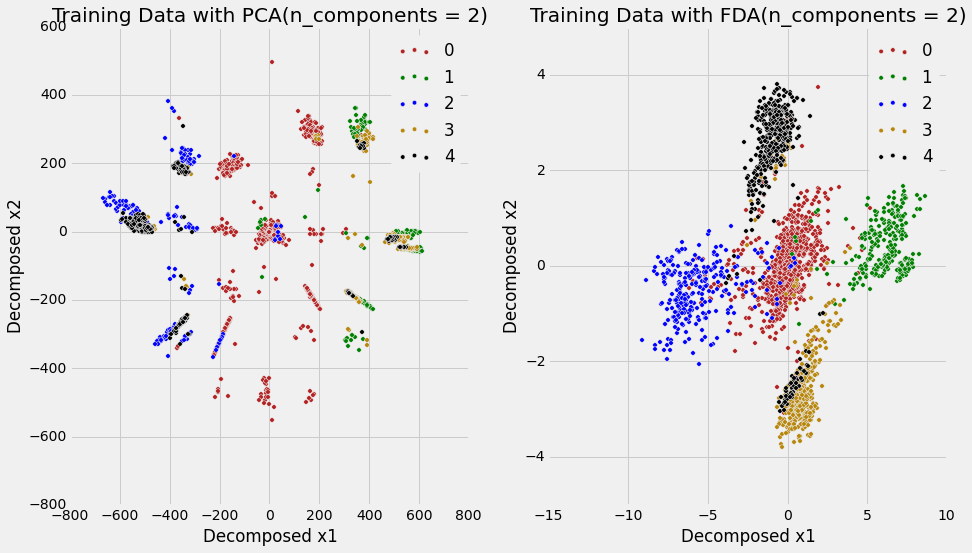

In [40]:
# color_map = ['r', 1='g', 2='b', 3='orange',4='bl')
color_map = ['firebrick', 'green', 'blue', 'darkgoldenrod', 'black']
def scatter_by_class(X, df, class_col):

    for g in set(df[class_col].tolist()):
        plt.scatter(X[np.where(df[class_col] == g),0], X[np.where(df[class_col] == g),1], c=color_map[g],  label=g)
    plt.legend()

pca = PCA(n_components=2)
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
X = pca.fit_transform(df[config['active_features']])
# plt.scatter(X[:,0],X[:,1], c=df['class'])
scatter_by_class(X, df, 'class')
plt.title('Training Data with PCA(n_components = 2)')
plt.xlabel('Decomposed x1')
plt.ylabel('Decomposed x2')


from sklearn.lda import LDA
plt.subplot(1,2,2)
lda = LDA(n_components=2)
X_lda = lda.fit_transform(df[active_features], df['class'])



# scatter_by_class(X, df, 'class')
# plt.scatter(X_lda[df[:,0],X_lda[:,1], c=df['class'])
scatter_by_class(X_lda, df, 'class')
plt.title("Training Data with FDA(n_components = 2)")
plt.xlabel('Decomposed x1')
plt.ylabel('Decomposed x2')

y_pred = lda.predict(df[active_features])
print sum(y_pred == df['class']) / float(len(df))

In [ ]:
class_col = 'class'
X[np.where(df[class_col] == 0),1]

In [ ]:
np.where(df[class_col] == 0)

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder


def compute_metrics(X_test, Y_test, Y_pred, label):
    i = label
    id_rated_t = X_test.index[Y_pred == i]
    id_is_t = X_test.index[Y_test == i]
    n = len(X_test)
    truths = set(id_is_t)
    positives = set(id_rated_t)
    tp = len(truths.intersection(positives))
    fp = len(positives.difference(truths.intersection(positives)))
    fn = len(truths.difference(truths.intersection(positives)))
    tn = n - tp - fp - fn


    precision = tp / float(max([1,fp + tp]))
    recall = tp / float(max([1,tp + fn]))
    accuracy = (tp + tn) / float(n)
    return (precision, recall, accuracy)

def train_split_classify(df, active_features, y_feature, clf, k = 4, verbose=False,
                        class_label_append = ''):
    X = df[active_features]
    Y = LabelEncoder().fit_transform(df[y_feature])
    classes = set(Y)
    accuracies = [[]]*len(classes)
    recalls = [[]]*len(classes)
    precisions = [[]]*len(classes)
    print '\n======\n'
    print 'Cross validating for', clf.__class__

    for i in xrange(k):
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.3, random_state=42
        )
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)

        for i in classes:

            precision, recall, accuracy = compute_metrics(X_test, Y_test, Y_pred, i)
            accuracies[i].append(accuracy)
            recalls[i].append(recall)
            precisions[i].append(precision)
            if verbose==True:
                print "Class", i 
                print 'precision', precision
                print 'recall', recall
                print 'accuracy', accuracy
                print '\n======'
    
    metrics = []
    for i in classes:
        metrics.append(dict(
            label=i,
            precision=np.mean(precisions[i]),
            recall=np.mean(recalls[i]),
            accuracy=np.mean(accuracies[i]),
            classifier=str(clf.__class__) + class_label_append,
            ))
    return metrics
#     print 'Confusion Matrix:', sum(cof_mat)
#     print 'Accuracy:', np.mean(accuracies)
#     print 'Recall:', np.mean(recalls)
#     print 'Precision:', np.mean(precisions)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


res = []
# svm = SVC()
# res += train_split_classify(df, config['active_features'], 'class',svm)

rf = RandomForestClassifier()
res += train_split_classify(df, config['active_features'], 'class',rf)

gbc = GradientBoostingClassifier()
res += train_split_classify(df, config['active_features'], 'class',gbc)

knn = KNeighborsClassifier(n_neighbors=10)
res += train_split_classify(df, config['active_features'], 'class',knn,  class_label_append='k=10')


knn2 = KNeighborsClassifier(n_neighbors=5)
res += train_split_classify(df, config['active_features'], 'class',knn2, class_label_append='k=5')


# combine results
df_res = pd.DataFrame(res)

In [ ]:
df_res.groupby('classifier').mean()[['accuracy', 'precision','recall']]

# Testing on Pure Test Data

In [ ]:
df_left_test = pd.read_csv('data/merged/look_left_test.csv')
df_right_test = pd.read_csv('data/merged/look_right_test.csv')

df_straight_test = pd.read_csv('data/merged/look_straight_test.csv')
### hack
# Assume class 0 is always when face is forward for any data set

# look-right events are class 3 and 4
df_right_test['class'] = df_right_test['class'].apply(lambda x: x + 2 if x > 0 else 0)
df_test = pd.concat([df_left_test, df_right_test, df_straight_test])


In [ ]:
active_features = config['active_features']

In [ ]:
def compute_test_data(df, df_test, clf):
    Y_test = df_test['class']
    classes = set(Y_test)
    X_test = df_test[active_features]
    clf.fit(df[active_features], df['class'])
    Y_pred = clf.predict(X_test)
    print 'PREDICTING TEST RESULTS FOR ', clf.__class__
    for i in classes:
        print i
        print compute_metrics(X_test, Y_test, Y_pred,i)

In [ ]:
active_features


In [ ]:
compute_test_data(df, df_test, rf)
compute_test_data(df, df_test, knn)

In [ ]:
Image(filename='data/merged/look_left_test-plots.png')


In [ ]:
Image(filename='data/merged/look_right_test-plots.png')


# PART 2: Feature Engineering

In [ ]:
# import cluster_merge
# %load_ext autoreload

In [ ]:
# from head_features import DeltaFeatureGenerator
# def apply_m_feature_engineering(df, relevant_features = []):
#     #return df
#     df_b = df.copy()
#     sub_frames = []
#     # these are all "historic" systems
#     ignore_columns = [c for c in df_b.columns.tolist() if c not in relevant_features]
#     sub_frames.append(DeltaFeatureGenerator().generate_features(
#             df, suffix='_6_steps', step=6,relevant_features=relevant_features, # eignore_columns,
#             ))

#     sub_frames.append(DeltaFeatureGenerator().generate_features(
#             df, suffix='_1_steps', step=1, relevant_features=relevant_features,
#             #ignore_columns=ignore_columns,
#             ))
#     df_new = pd.concat(sub_frames, axis=1)
#     df_new['pos_delta_x'] = df_new['noseX_1_steps'] > 0 
#     active_features = df_new.columns.values.tolist()
#     for c in df.columns.values.tolist():
#         if not c in df_new.columns.values.tolist():
#             df_new[c] = df[c]
#     return df_new, active_features



In [ ]:
# window_size = 3
# df_left, new_active_features = cluster_merge.generate_training_set(
#     'data/look_left', 
#     k = 3,
#     verbose=False,
#     window_size=window_size,
#     feature_generator = apply_m_feature_engineering,
#     relevant_features=config['relevant_features']
#     )

# df_right, new_active_features = cluster_merge.generate_training_set(
#     'data/look_right', 
#     k = 3,
#     verbose=False,
#     window_size=window_size,
#     feature_generator = apply_m_feature_engineering,
#     relevant_features=config['relevant_features']
#     )

# df_straight, new_active_features = cluster_merge.generate_training_set(
#     'data/look_straight', 
#     k = 1,
#     verbose=False,
#     window_size=window_size,
#     feature_generator = apply_m_feature_engineering,
#     relevant_features=config['relevant_features']
#     )
# df_right['class'] = df_right['class'].apply(lambda x: x + 2 if x > 0 else 0)
# df_trains = pd.concat([df_left, df_right, df_straight]) 

In [ ]:
plt.figure(figsize=(50,3))
plt.scatter(xrange(len(df_trains)), df_trains['noseX'], c=df_trains['class'])


In [ ]:

pca = PCA(n_components=2)
X = pca.fit_transform(df_trains[new_active_features])
plt.scatter(X[:,0],X[:,1], c=df_trains['class'])
plt.title('Training Data with PCA(n_components = 2)')

plt.legend()
from sklearn.lda import LDA
lda = LDA(n_components=2)
X = lda.fit_transform(df_trains[new_active_features], df_trains['class'])
plt.figure()

plt.scatter(X[:,0],X[:,1], c=df_trains['class'])
plt.title("Training Data with FDA(n_components = 2)")

y_pred = lda.predict(df_trains[new_active_features])
print sum(y_pred == df_trains['class']) / float(len(df))

In [ ]:
df_trains[['pos_delta_x_1', 'pos_delta_x_0']]